In [431]:
df_temp = pd.read_csv('EURUSD_15m_BID_01.01.2010-31.12.2016.csv', nrows=1)
print(df_temp.columns)

Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [432]:
import pandas as pd
import numpy as np

def load_stock_data(filename):
    # Reads the file (it can be tab or comma separated, adjust sep if needed)
    df = pd.read_csv(filename, sep=None, engine='python')

    # Clean column names (remove spaces and fix case)
    df.columns = [col.strip().capitalize() for col in df.columns]

    # Parse 'Time' column as datetime
    df['Datetime'] = pd.to_datetime(df['Time'])
    df.drop(columns=['Time', 'Volume'], inplace=True)

    # Set as index and sort
    df.set_index('Datetime', inplace=True)
    df.sort_index(inplace=True)


    return df

# Example usage
df = load_stock_data('EURUSD_15m_BID_01.01.2010-31.12.2016.csv')
print(df.head())

                        Open     High      Low    Close
Datetime                                               
2010-01-01 00:00:00  1.43283  1.43293  1.43224  1.43293
2010-01-01 00:15:00  1.43285  1.43295  1.43229  1.43275
2010-01-01 00:30:00  1.43280  1.43303  1.43239  1.43281
2010-01-01 00:45:00  1.43285  1.43294  1.43229  1.43276
2010-01-01 01:00:00  1.43287  1.43292  1.43206  1.43282


##### 2019-01-01 and 2019-04-30 4 hour data

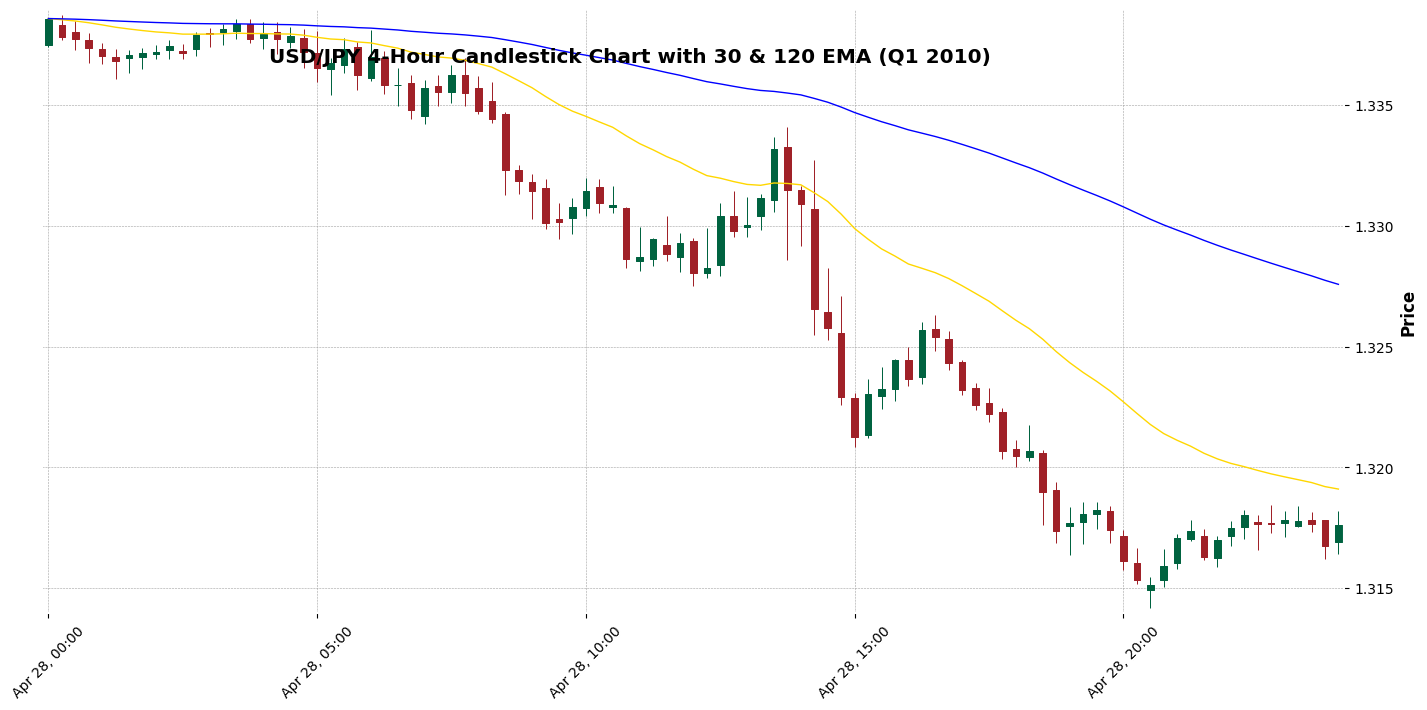

In [462]:
import pandas as pd
import mplfinance as mpf

# Filter 2019 Q1 using datetime index
df_2019_q1 = df[(df.index >= '2010-04-28') & (df.index <= '2010-04-29')].copy()

"""  
# Resample to 4-hour intervals
df_4h = df_2019_q1.resample('4H').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last'
}).dropna()

"""
df_4h = df_2019_q1.copy()

# Calculate 30 and 120 period EMAs on 'Close'
df_4h['EMA_30'] = df_4h['Close'].ewm(span=30, adjust=False).mean()
df_4h['EMA_120'] = df_4h['Close'].ewm(span=120, adjust=False).mean()

df_4h['trend'] = np.where(df_4h['EMA_30'] > df_4h['EMA_120'], 'bullish', 
                    np.where(df_4h['EMA_30'] < df_4h['EMA_120'],'bearish', np.nan))
df_4h["Green"] = np.select(
    [df_4h["Close"] > df_4h["Open"], df_4h["Close"] < df_4h["Open"]],
    [True, False],
    default=pd.NA
).astype("object")  # <- 'boolean' not 'bool'
df_4h['label'] = np.nan

# Plot candlestick chart with EMAs
mpf.plot(df_4h[['Open', 'High', 'Low', 'Close']],
         type='candle',
         style='charles',
         title='USD/JPY 4-Hour Candlestick Chart with 30 & 120 EMA (Q1 2010)',
         ylabel='Price',
         volume=False,
         figsize=(15, 7),
         tight_layout=True,
         addplot=[
             mpf.make_addplot(df_4h['EMA_30'], color='gold', width=1),
             mpf.make_addplot(df_4h['EMA_120'], color='blue', width=1)
         ])


#### Fib

In [463]:
print(df_4h[0:])

                        Open     High      Low    Close    EMA_30   EMA_120  \
Datetime                                                                      
2010-04-28 00:00:00  1.33749  1.33863  1.33740  1.33859  1.338590  1.338590   
2010-04-28 00:15:00  1.33833  1.33873  1.33768  1.33782  1.338540  1.338577   
2010-04-28 00:30:00  1.33803  1.33849  1.33730  1.33774  1.338489  1.338563   
2010-04-28 00:45:00  1.33772  1.33799  1.33673  1.33736  1.338416  1.338544   
2010-04-28 01:00:00  1.33731  1.33757  1.33672  1.33703  1.338326  1.338519   
...                      ...      ...      ...      ...       ...       ...   
2010-04-28 23:00:00  1.31768  1.31819  1.31710  1.31782  1.319604  1.328277   
2010-04-28 23:15:00  1.31757  1.31840  1.31753  1.31779  1.319487  1.328104   
2010-04-28 23:30:00  1.31781  1.31815  1.31734  1.31765  1.319369  1.327931   
2010-04-28 23:45:00  1.31780  1.31783  1.31622  1.31676  1.319200  1.327746   
2010-04-29 00:00:00  1.31689  1.31821  1.31640  1.31

In [464]:
print(df_4h.columns)


Index(['Open', 'High', 'Low', 'Close', 'EMA_30', 'EMA_120', 'trend', 'Green',
       'label'],
      dtype='object')


In [465]:
import matplotlib.patches as patches

def plot_fibonacci_candlestick(df, start_idx, end_idx, levels=None, trend="bearish", entry_signal=None, engulfing_candle=None, R=None, pip_size=0.0010):

    if levels is None:
        levels = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]

    df_slice = df.iloc[start_idx:end_idx + 2 + 1].copy()
    min_price = df_slice['Low'].min()
    max_price = df_slice['High'].max()

    fib_lines = []
    fib_labels = []

    for level in levels:
        if trend == "bearish":
            y = min_price + (max_price - min_price) * level
        else:
            y = max_price - (max_price - min_price) * level

        line_data = [np.nan] * len(df)
        line_data[start_idx:end_idx + 1] = [y] * (end_idx - start_idx + 1)

        fib_lines.append(mpf.make_addplot(
            line_data,
            color='gray', linestyle='--', width=0.7
        ))

        fib_labels.append((level, y))

    # Add EMAs
    ema_30_plot = mpf.make_addplot(df['EMA_30'], color='gold', width=1.2, panel=0)
    ema_120_plot = mpf.make_addplot(df['EMA_120'], color='blue', width=1.2, panel=0)

    all_addplots = fib_lines + [ema_30_plot, ema_120_plot]

    # Entry Signal
    if entry_signal is not None and 0 <= entry_signal < len(df):
        entry_price = df['Close'].iloc[entry_signal]
        marker = '^' if trend == "bullish" else 'v'
        color = 'green' if trend == "bullish" else 'red'
        signal_plot = mpf.make_addplot(
            [entry_price if i == entry_signal else np.nan for i in range(len(df))],
            type='scatter',
            markersize=100,
            marker=marker,
            color=color
        )
        all_addplots.append(signal_plot)

    # Plot candlestick chart first
    fig, axlist = mpf.plot(df,
                           type='candle',
                           style='yahoo',
                           addplot=all_addplots,
                           title='Fibonacci Retracement with EMA and Reward Box',
                           ylabel='Price',
                           volume=False,
                           returnfig=True)

    ax = axlist[0]

    # ✅ Reward box drawing only if engulfing_candle is not None
    if R is not None and engulfing_candle is not None:
        candle = df.iloc[engulfing_candle]
        close_price = candle['Close']

        # Box width (horizontal span)
        box_left = engulfing_candle - 1
        box_right = engulfing_candle + 10
        width = box_right - box_left

        # --- Red Box (Risk area) ---
        red_top = close_price + pip_size
        red_bottom = close_price
        red_height = abs(red_top - red_bottom)
        red_y = min(red_top, red_bottom)

        red_box = patches.Rectangle(
            (box_left, red_y),
            width,
            red_height,
            linewidth=0,
            edgecolor=None,
            facecolor='red',
            alpha=0.3,
            zorder=0
        )
        ax.add_patch(red_box)

        # --- Green Box (Reward area) ---
        green_top = close_price
        green_bottom = close_price - R * pip_size
        green_height = abs(green_top - green_bottom)
        green_y = min(green_top, green_bottom)

        green_box = patches.Rectangle(
            (box_left, green_y),
            width,
            green_height,
            linewidth=0,
            edgecolor=None,
            facecolor='green',
            alpha=0.3,
            zorder=0
        )
        ax.add_patch(green_box)

    # Annotate Fib levels
    for level, y in fib_labels:
        label_text = f"{level:.3f}"
        ax.annotate(label_text,
                    xy=(end_idx, y),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='left',
                    va='center',
                    fontsize=8,
                    color='gray')

    plt.show()
    return fib_labels


##### Detect peak / trough

[8] State changed: IDLE → PULLBACK_DETECTED
[20] State changed: PULLBACK_DETECTED → BREAK_OF_STRUCTURE


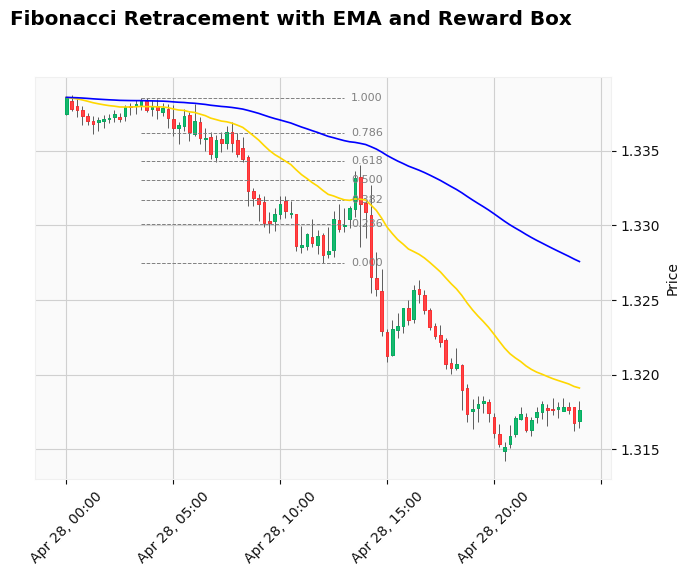

[54] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY
[57] State changed: WAITING_ENTRY → BREAK_OF_STRUCTURE


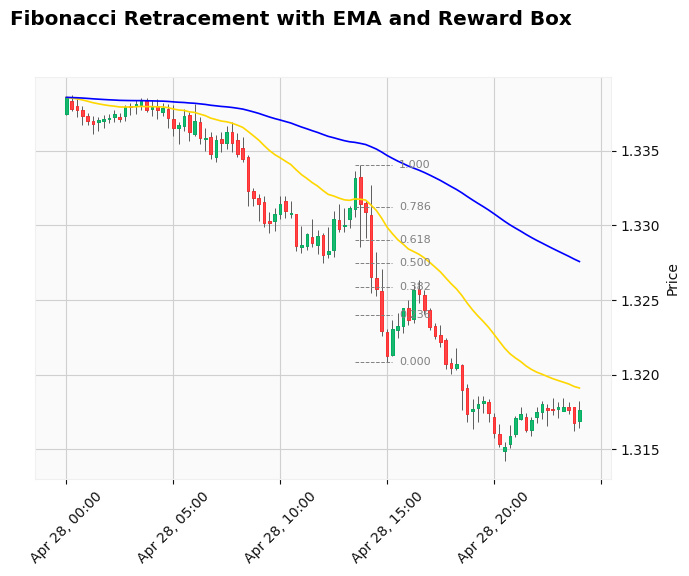

[63] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY
[71] State changed: WAITING_ENTRY → BREAK_OF_STRUCTURE


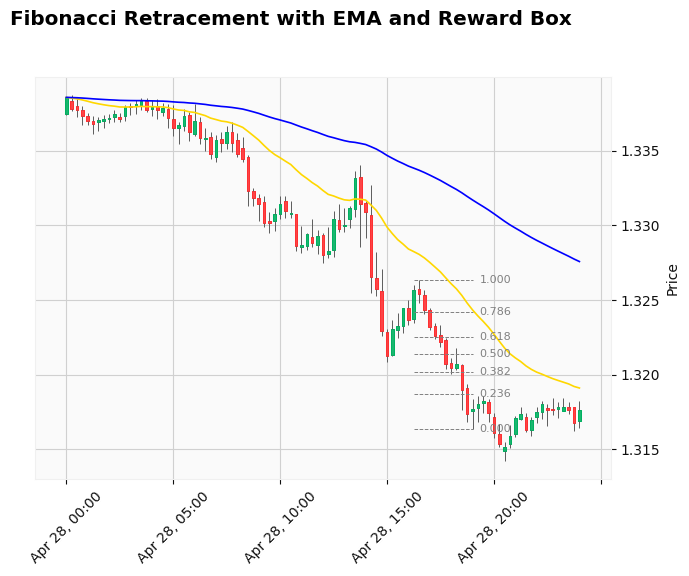

[78] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY
[80] State changed: WAITING_ENTRY → BREAK_OF_STRUCTURE


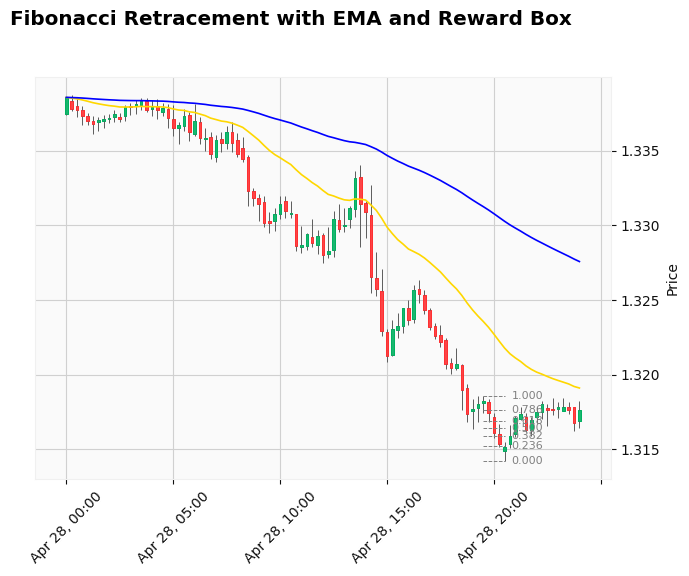

[84] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY


C:\Users\user\AppData\Local\Temp\ipykernel_54804\404060190.py:75: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'signal_label' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.df.loc[self.df.index[idx], "label"] = 'signal_label'


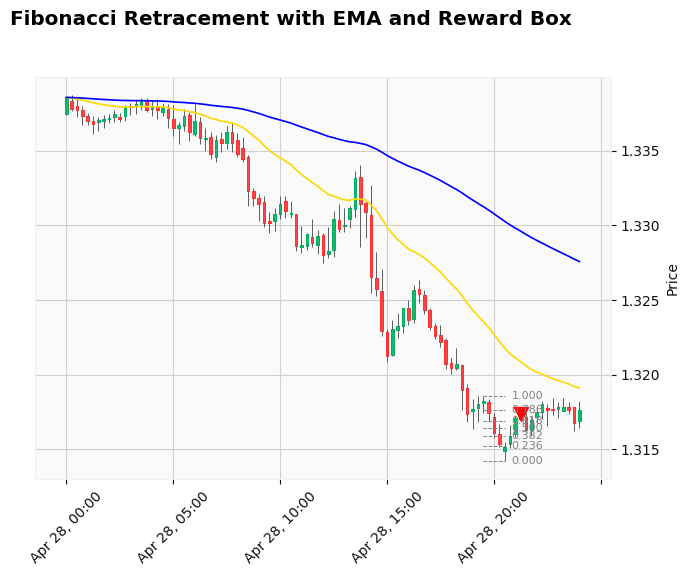

[85] State changed: WAITING_ENTRY → ENTRY_SIGNAL


In [466]:
import pandas as pd
import numpy as np

class BearishFSM: # Finite State Machine
    def __init__(self, df):
        self.df = df
        self.state = "IDLE"
        self.low_price = None
        self.low_price_idx = None
        self.high_price = None
        self.high_price_idx = None
        self.high_price_relative_idx = None
        self.fib_labels = []
        self.fib_dict = {} # not a must to initialize, just for good habit
        self.entry_signal_idx = None
        

    def update(self, idx):
        trend = self.df['trend'].values
        prices = self.df["Close"].values
        greens = self.df["Green"].values
        opens = self.df["Open"].values
        closes = self.df["Close"].values
        

        current_trend = trend[idx]
        prev_trend = trend[idx - 1]

        if current_trend != prev_trend:
            self.reset()
            print(f"[{idx}] Trend changed from {prev_trend} to {current_trend}, reset state to IDLE")

        if current_trend == "bearish":
            if self.state == "IDLE":
                if all(greens[idx - i] is True for i in range(3)): # pullback
                    self.low_price = prices[idx - 2]
                    self.low_price_idx = idx - 2
                    prev_state = self.state
                    self.state = "PULLBACK_DETECTED"
                    print(f"[{idx}] State changed: {prev_state} → {self.state}")

            elif self.state == "PULLBACK_DETECTED":
                if prices[idx] < self.low_price:
                    prev_state = self.state
                    self.state = "BREAK_OF_STRUCTURE"
                    print(f"[{idx}] State changed: {prev_state} → {self.state}")

            elif self.state == "BREAK_OF_STRUCTURE":
                if all(greens[idx - i] is True for i in range(3)) and prices[idx] < self.low_price:
                    # Define high price for Fib retrace
                    self.high_price = prices[self.low_price_idx:idx - 2].max()
                    self.high_price_relative_idx = np.argmax(prices[self.low_price_idx: idx - 2])
                    self.high_price_idx = self.low_price_idx + self.high_price_relative_idx
                    # Low price for confirming the next Lower high
                    self.low_price = prices[idx - 2]
                    self.low_price_idx = idx - 2
                    self.fib_labels = plot_fibonacci_candlestick(self.df, self.high_price_idx, self.low_price_idx, trend="bearish")
                    self.fib_dict = dict(self.fib_labels)
                    prev_state = self.state
                    self.state = "WAITING_ENTRY"
                    print(f"[{idx}] State changed: {prev_state} → {self.state}")

                elif all(greens[idx - i] is True for i in range(3)) and prices[idx] >= self.low_price:
                    self.low_price = prices[idx - 2]
                    self.low_price_idx = idx - 2
                    prev_state = self.state
                    self.state = "PULLBACK_DETECTED"
                    print(f"[{idx}] State changed: {prev_state} → {self.state}")

            elif self.state == "WAITING_ENTRY":
                fib_618_price = self.fib_dict.get(0.618)
                fib_000_price = self.fib_dict.get(0.000)
                if fib_618_price and prices[idx] >= fib_618_price: # price rebound back to 0.618
                    self.entry_signal_idx = idx
                    self.df.loc[self.df.index[idx], "label"] = 'signal_label'
                    plot_fibonacci_candlestick(self.df, self.high_price_idx, self.low_price_idx, trend="bearish", entry_signal=idx)
                    prev_state = self.state
                    self.state = "ENTRY_SIGNAL"
                    print(f"[{idx}] State changed: {prev_state} → {self.state}")

                elif fib_618_price and prices[idx] <= fib_000_price: # price lower than 0.000
                    prev_state = self.state
                    self.state = "BREAK_OF_STRUCTURE"
                    print(f"[{idx}] State changed: {prev_state} → {self.state}")
            
            elif self.state == "ENTRY_SIGNAL": 
                fib_100_price = self.fib_dict.get(1.000)
                fib_000_price = self.fib_dict.get(0.000)

                if prices[idx] >= fib_100_price: # no matter what, if the candle pass 1.00, we do not trade
                    prev_state = self.state
                    self.state = "PULLBACK_DETECTED"
                    print(f"[{idx}] State changed: {prev_state} → {self.state}")

                # Bearish Engulfing candle ( the candle can break 0.00 and we still trade)
                elif (greens[idx - 1] is True) and (greens[idx] is not True) and opens[idx] > closes[idx - 1] and closes[idx] < opens[idx - 1]: # current red , prev green candle, current open > prev close, current close < prev open
                    plot_fibonacci_candlestick(
                    self.df, self.high_price_idx, self.low_price_idx, trend="bearish",
                    entry_signal=idx, engulfing_candle=idx, R=2, pip_size=0.01
                )
                    prev_state = self.state
                    self.state = "ENTER_MARKET"
                    print(f"[{idx}] State changed: {prev_state} → {self.state}")
                    
                elif prices[idx] <= fib_000_price: # If candle breaks 0.00 before there is a Bearish ENGULFING candle
                    prev_state = self.state
                    self.state = "BREAK_OF_STRUCTURE"
                    print(f"[{idx}] State changed: {prev_state} → {self.state}")

            elif self.state == "ENTER_MARKET":
                self.reset()
                print(f"[{idx}] Reached ENTER_MARKET — resetting FSM to IDLE")                  # need to apply actual logic to execute trade
                    
    

                    

        # if current_trend == "bullish":
    

    def reset(self):
        self.state = "IDLE"
        self.low_price = None
        self.low_price_idx = None
        self.high_price = None
        self.high_price_idx = None
        self.high_price_relative_idx = None
        self.fib_labels = []
        self.fib_dict = {} 
        self.entry_signal_idx = None


fsm = BearishFSM(df_4h)
for idx in range(2, len(df_4h)):
    fsm.update(idx)



Low price index:  6
break_of_structure : 20
14 52


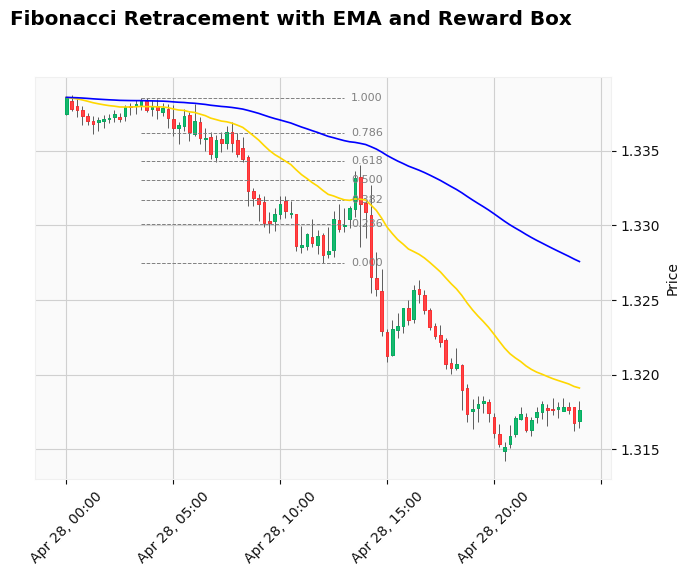

In [467]:
import pandas as pd

trend = df_4h["trend"].values

prices = df_4h['Close'].values
dates = df_4h.index.values
greens =  df_4h['Green'].values
opens = df_4h['Open'].values
closes = df_4h['Close'].values

low_price = None
low_price_idx = None
high_price = None
high_price_relative_idx = None
high_price_idx = None
pullback = False
break_of_structure = False
waiting_pull_back = False
entry_signal = False
fib_labels = []

if len(prices) < 3:
    print("Not enough data for inflection points.")
else:
    for idx in range(2, len(prices)):

        current_trend = trend[idx]

        # If trend changes, reset all
        if current_trend != trend[idx - 1]: 
            low_price = low_price_idx = None
            high_price = high_price_idx = high_price_relative_idx = None
        
        # find pullback
        if current_trend == "bearish":
            
            if (greens[idx] == True and greens[idx-1] == True and greens[idx-2] == True) and (pullback == False) and (waiting_pull_back == False) : # first pullback

                pullback = True
                low_price =  prices[idx - 2]
                low_price_idx = idx - 2
                print("Low price index: ", low_price_idx)

            elif (low_price is not None) and (prices[idx] < low_price) and (waiting_pull_back == False) and break_of_structure == False: # break of previous low point structure
                break_of_structure = True
                print("break_of_structure :", idx)

            elif (pullback == True) and (break_of_structure == True) and (greens[idx] == True and greens[idx-1] == True and greens[idx-2] == True): # ready to plot fib
                pullback = False
                break_of_structure = False
                waiting_pull_back = True

                high_price = prices[low_price_idx: idx-2].max()
                high_price_relative_idx = np.argmax(prices[low_price_idx: idx-2])
                high_price_idx = low_price_idx + high_price_relative_idx

                # High and low price co-exist
                print(high_price_idx,idx - 2)  
                low_price =  prices[idx - 2]
                low_price_idx = idx - 2
                fib_labels = plot_fibonacci_candlestick(df_4h, high_price_idx, low_price_idx, trend="bearish")   
                
                
            
            if waiting_pull_back and fib_labels:
                # Extract the y-value (price) for the 0.618 level
                fib_618_price = next((y for level, y in fib_labels if abs(level - 0.618) < 1e-5), None)
                # print(fib_618_price)
                if fib_618_price is not None and prices[idx] >= fib_618_price:
                    entry_signal = True
                    # Price has reached or exceeded the 0.618 retracement level
                    df_4h.loc[df.index[idx], 'label'] = 'signal_label'
                    waiting_pull_back = False  # reset the state
                    plot_fibonacci_candlestick(df_4h, high_price_idx, low_price_idx, trend="bearish", entry_signal=idx) 
                    

            if entry_signal == True and (greens[idx-1] == True) and (greens[idx] == False) and (opens[idx] > closes[idx-1]) and (closes[idx] < opens[idx-1]): 
                entry_signal = False
                # Find bearish engulfing candle, which is a sign that bears are regaining control
                plot_fibonacci_candlestick(df_4h, high_price_idx, low_price_idx, trend="bearish", entry_signal=idx, engulfing_candle = idx, R = 2, pip_size =0.01) 
                high_price = high_price_relative_idx = high_price_idx = None
                low_price = low_price_idx = None


##### Visualize on peak and trough

##### HH, HL, LH, LL

In [468]:
df_4h['trend'] = np.nan
df_4h['label'] = np.nan
# df_4h = df_4h.drop(columns=['TICKVOL', 'VOL', 'SPREAD'])
print(df_4h.head())

                        Open     High      Low    Close    EMA_30   EMA_120  \
Datetime                                                                      
2010-04-28 00:00:00  1.33749  1.33863  1.33740  1.33859  1.338590  1.338590   
2010-04-28 00:15:00  1.33833  1.33873  1.33768  1.33782  1.338540  1.338577   
2010-04-28 00:30:00  1.33803  1.33849  1.33730  1.33774  1.338489  1.338563   
2010-04-28 00:45:00  1.33772  1.33799  1.33673  1.33736  1.338416  1.338544   
2010-04-28 01:00:00  1.33731  1.33757  1.33672  1.33703  1.338326  1.338519   

                     trend  Green  label  
Datetime                                  
2010-04-28 00:00:00    NaN   True    NaN  
2010-04-28 00:15:00    NaN  False    NaN  
2010-04-28 00:30:00    NaN  False    NaN  
2010-04-28 00:45:00    NaN  False    NaN  
2010-04-28 01:00:00    NaN  False    NaN  


In [469]:
last_high = None
last_high_idx = None
last_low = None

if 'label' not in df_4h.columns:
    df_4h['label'] = np.nan
if 'trend' not in df_4h.columns:
    df_4h['trend'] = np.nan


# Loop through the DataFrame starting from a safe index
for idx in range(len(df_4h)):
    
    ema_30 = df_4h["EMA_30"].iloc[idx]
    ema_120 = df_4h["EMA_120"].iloc[idx]

    # Skip if either EMA is NaN (early rows)
    if np.isnan(ema_30) or np.isnan(ema_120):
        continue

    if ema_30 > ema_120:
        current_trend = "bullish"

    elif ema_30 < ema_120:
        current_trend = "bearish"
        
    else:
        # Handle the case when they are equal
        if idx == 0 or pd.isna(df_4h["trend"].iloc[idx-1]):
            continue  # not enough history to determine trend change
        previous_trend = df_4h["trend"].iloc[idx-1]
        current_trend = "bearish" if previous_trend == "bullish" else "bullish"
    
    current_point = df_4h["point"].iloc[idx]
    current_price = df_4h["Close"].iloc[idx]

    if current_trend == "bullish":
        pass  # You might want to implement bullish logic later
    
    elif current_trend == "bearish":
        if current_point == "low":
            if last_low is None:
                df_4h.loc[df_4h.index[idx], 'label'] = "L"
                last_low = current_price
            else:
                if current_price < last_low:
                    df_4h.loc[df_4h.index[idx], 'label'] = "LL"
                    
                    plot_fibonacci_candlestick(df_4h, start_idx=last_high_idx, end_idx=idx)
                    df_4h.loc[df_4h.index[last_high_idx], 'label'] = "LH"
                    last_low = current_price
                else:
                    last_low = current_price

        elif current_point == "high":
            if last_high is None:
                df_4h.loc[df_4h.index[idx], 'label'] = "H"
            if (df_4h["Close"].iloc[idx-1] > df_4h["Open"].iloc[idx-1]) and (df_4h["Close"].iloc[idx-2] > df_4h["Open"].iloc[idx-2]): # confirm there is 3 bullish conseq
                last_high = current_price
                last_high_idx = idx
            

    df_4h.loc[df_4h.index[idx], 'trend'] = current_trend

KeyError: 'point'